# 🤖 Notebook 03: Model Training & Selection

**Predicting F1 Race Finishing Positions Using Practice & Qualifying Data**

This notebook trains and compares three models:
1. **Baseline**: Linear Regression (grid position only)
2. **Random Forest**: Ensemble of decision trees
3. **XGBoost**: Gradient-boosted trees

Training on 2022–2024, Cross-validation with GroupKFold.

In [1]:
import sys, os, warnings
warnings.filterwarnings('ignore')
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import config
from src.feature_engineering import load_feature_matrix
from src.model import (
    prepare_data,
    train_baseline,
    train_random_forest,
    train_xgboost,
    evaluate_model,
    get_feature_importance,
    train_and_evaluate,
)
from src.utils import (
    plot_feature_importance,
    plot_predicted_vs_actual,
    plot_model_comparison,
)

sns.set_theme(style='whitegrid')
%matplotlib inline

## 1. Load Feature Matrix

In [2]:
# Load pre-built feature matrix
df = load_feature_matrix()
print(f"Feature matrix: {df.shape}")

# Train/Test split
train_df = df[df['Year'].isin(config.TRAIN_YEARS)].copy()
test_df = df[df['Year'].isin(config.TEST_YEARS)].copy()

print(f"Training: {len(train_df)} samples ({config.TRAIN_YEARS})")
print(f"Testing:  {len(test_df)} samples ({config.TEST_YEARS})")
print(f"\nAvailable features: {[c for c in config.ALL_FEATURES if c in df.columns]}")

Feature matrix: (1397, 51)
Training: 918 samples ([2023, 2024])
Testing:  479 samples ([2025])

Available features: ['fp_best_lap', 'fp2_long_run_avg', 'fp_consistency', 'fp_avg_speed_i1', 'fp_avg_speed_i2', 'fp_avg_speed_st', 'grid_position', 'quali_best_time', 'quali_gap_to_pole', 'circuit_encoded', 'is_street_circuit', 'track_temp_avg', 'rainfall', 'humidity_avg', 'wind_speed_avg', 'driver_recent_avg_pos', 'team_recent_avg_pos', 'team_encoded', 'driver_encoded', 'grid_vs_recent_form', 'fp_race_pace_delta', 'quali_position_change', 'driver_consistency_score', 'team_quali_avg', 'position_delta_potential', 'sector_speed_rank_i1', 'sector_speed_rank_i2', 'fp_n_compounds_used', 'fp_soft_pct', 'fp_stint_count', 'fp_avg_tyre_life', 'driver_circuit_avg_pos', 'team_circuit_avg_pos', 'driver_circuit_best_pos', 'driver_dnf_rate', 'team_dnf_rate']


## 2. Train All Models

Run the full training pipeline with hyperparameter tuning.

In [3]:
# Full training and evaluation pipeline
pipeline_results = train_and_evaluate(df, tune=True)


Training set: 918 samples ([2023, 2024])
Test set: 479 samples ([2025])
Total features: 36

── Training Baseline ──
  MAE: 3.411, Spearman: 0.652

── Training Random Forest ──
  Tuning Random Forest (Optuna)...
  Best RF params: {'n_estimators': 300, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt'}
  MAE: 3.253, Spearman: 0.67

── Training XGBoost ──
  Tuning XGBoost (Optuna)...
  Best XGB params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01594573996384261, 'subsample': 0.6154897603081889, 'colsample_bytree': 0.8992357456867728, 'min_child_weight': 9, 'reg_alpha': 0.0015914915831927807, 'reg_lambda': 6.476489920093153}
  MAE: 3.202, Spearman: 0.66

── Training LightGBM ──
  Tuning LightGBM (Optuna)...
  Best LGBM params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.009689157979499551, 'subsample': 0.900327718178962, 'colsample_bytree': 0.6836597766853224, 'min_child_samples': 18, 'reg_alpha': 0.0020260075386764466, 'reg

## 3. Model Comparison

In [4]:
# Results table
results = pipeline_results['results']
comparison_df = pd.DataFrame(results).T
print("\n── Model Comparison (2025 Test Set) ──")
display(comparison_df)


── Model Comparison (2025 Test Set) ──


,model,mae,rmse,spearman_rho,spearman_p,per_race_spearman,top3_accuracy,ndcg_10
baseline,Baseline (Grid Position),3.411,4.367,0.652,0.0,0.651,0.75,0.959
random_forest,Random Forest,3.253,4.205,0.67,0.0,0.662,0.764,0.952
xgboost,XGBoost,3.202,4.255,0.66,0.0,0.655,0.75,0.902
lightgbm,LightGBM,3.239,4.279,0.655,0.0,0.651,0.708,0.894
stacking,Stacking Ensemble,3.121,4.226,0.67,0.0,0.662,0.764,0.952
weighted_avg,Weighted Average,3.221,4.234,0.663,0.0,0.657,0.75,0.95


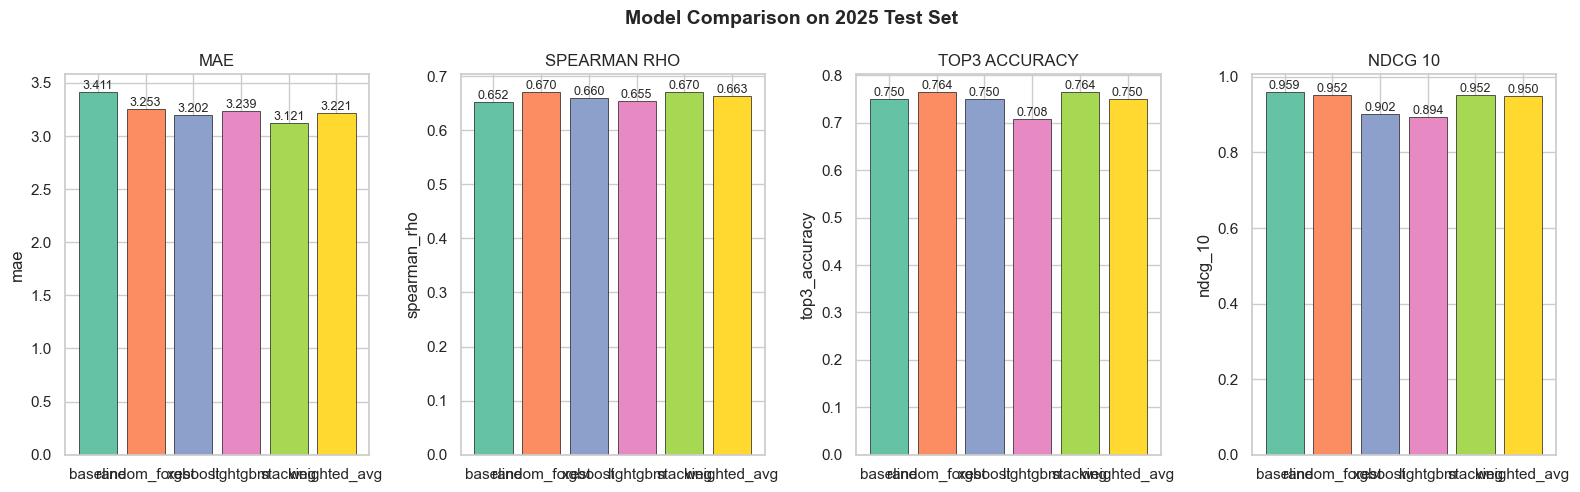

In [5]:
# Visual comparison
fig = plot_model_comparison(results)
plt.show()

## 4. Feature Importance


── Feature Importance (Best Model) ──


,feature,importance,importance_pct
0,grid_position,0.200261,20.0
1,quali_gap_to_pole,0.105498,10.5
2,team_quali_avg,0.085768,8.6
3,team_recent_avg_pos,0.062370,6.2
4,driver_recent_avg_pos,0.038244,3.8
5,position_delta_potential,0.022328,2.2
6,quali_position_change,0.021611,2.2
7,driver_consistency_score,0.020554,2.1
8,rainfall,0.019968,2.0
9,fp_soft_pct,0.019387,1.9


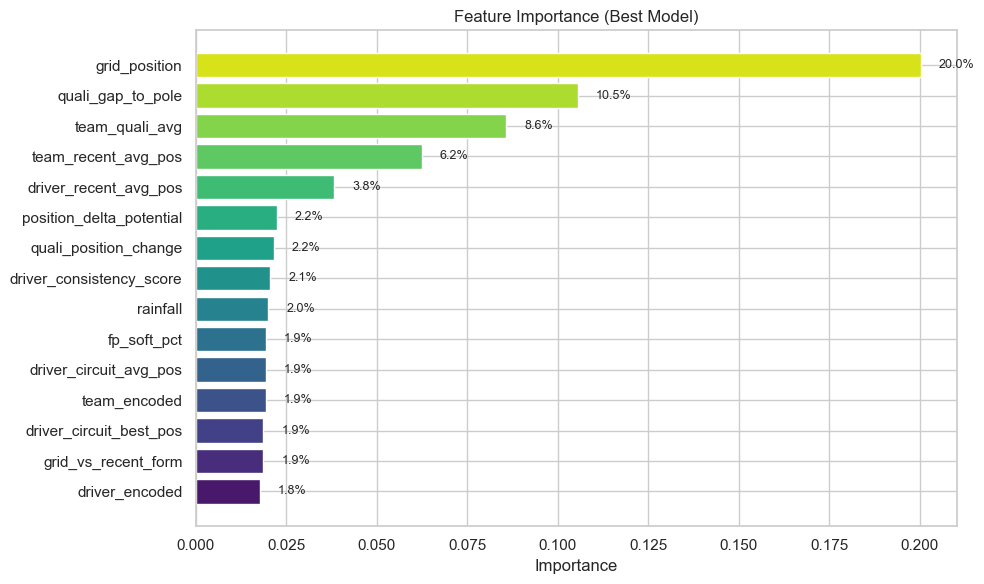

In [6]:
# Feature importance from the best model
fi = pipeline_results['feature_importance']
if not fi.empty:
    print("\n── Feature Importance (Best Model) ──")
    display(fi)
    
    fig = plot_feature_importance(fi, title='Feature Importance (Best Model)')
    plt.show()

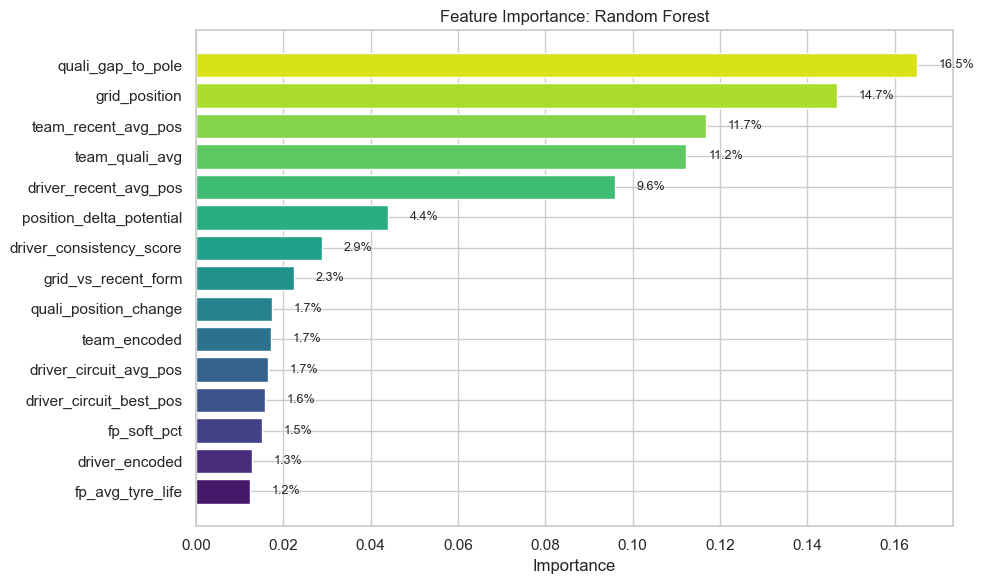

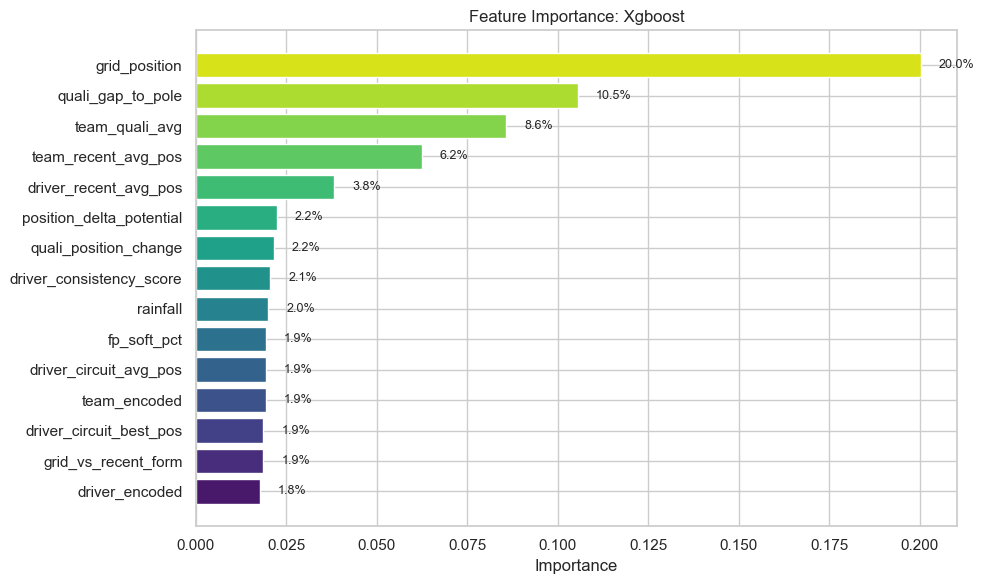

In [7]:
# Feature importance for each tree model
models = pipeline_results['models']
feature_cols = pipeline_results['feature_cols']

for name in ['random_forest', 'xgboost']:
    model = models[name]
    if model is not None:
        fi_model = get_feature_importance(model, feature_cols)
        fig = plot_feature_importance(fi_model, title=f'Feature Importance: {name.replace("_", " ").title()}')
        plt.show()

## 5. Predicted vs Actual

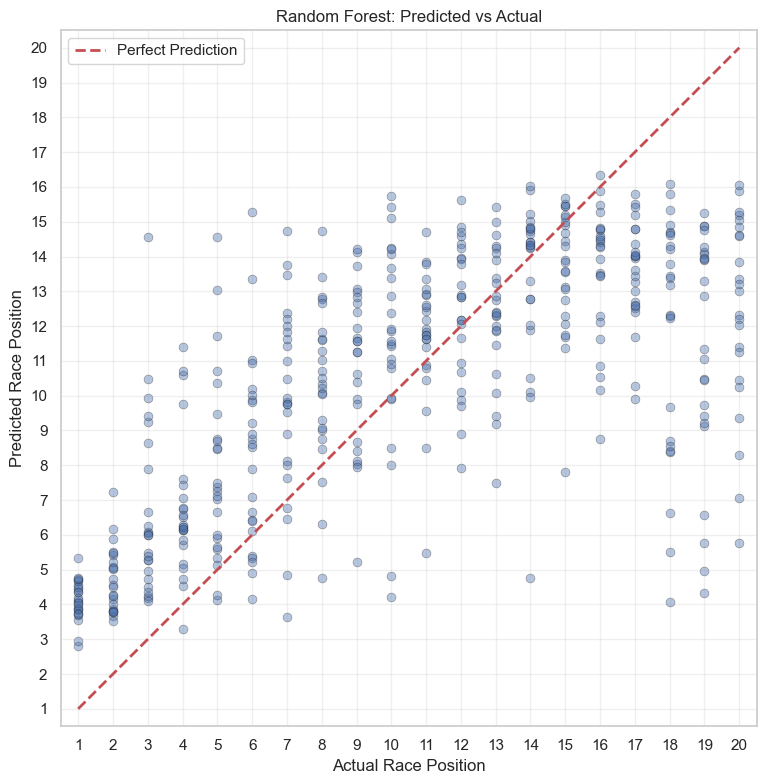

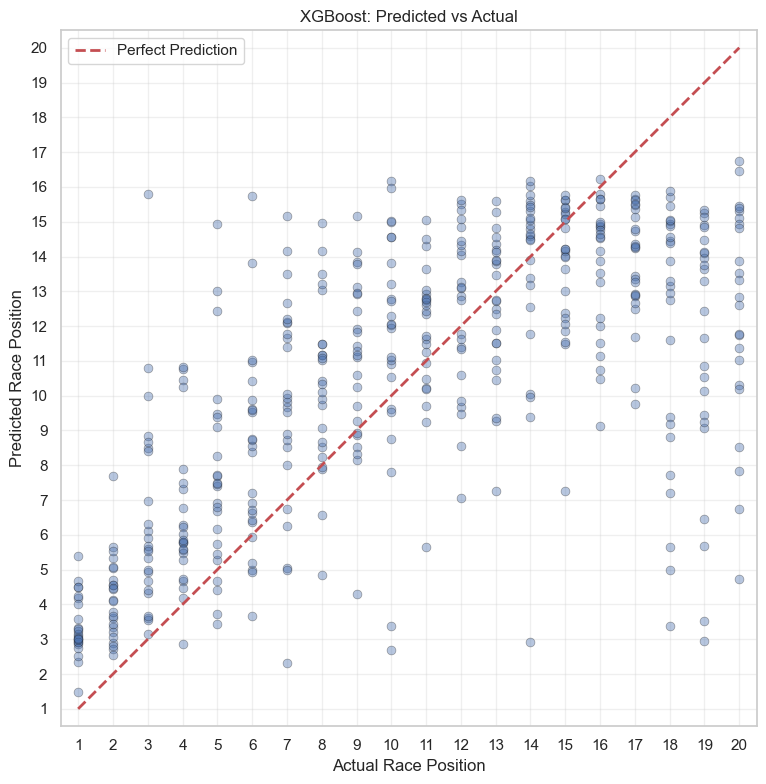

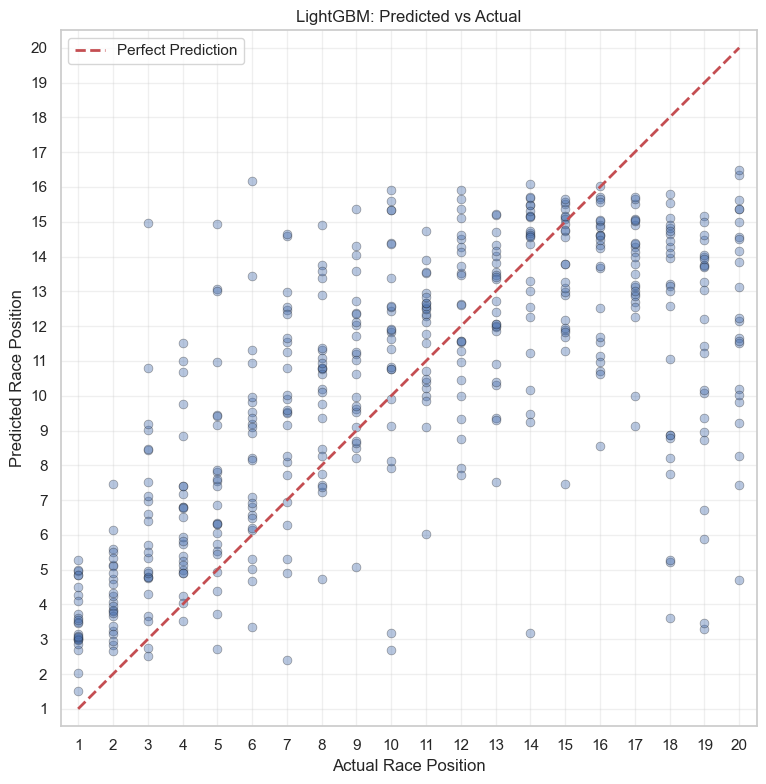

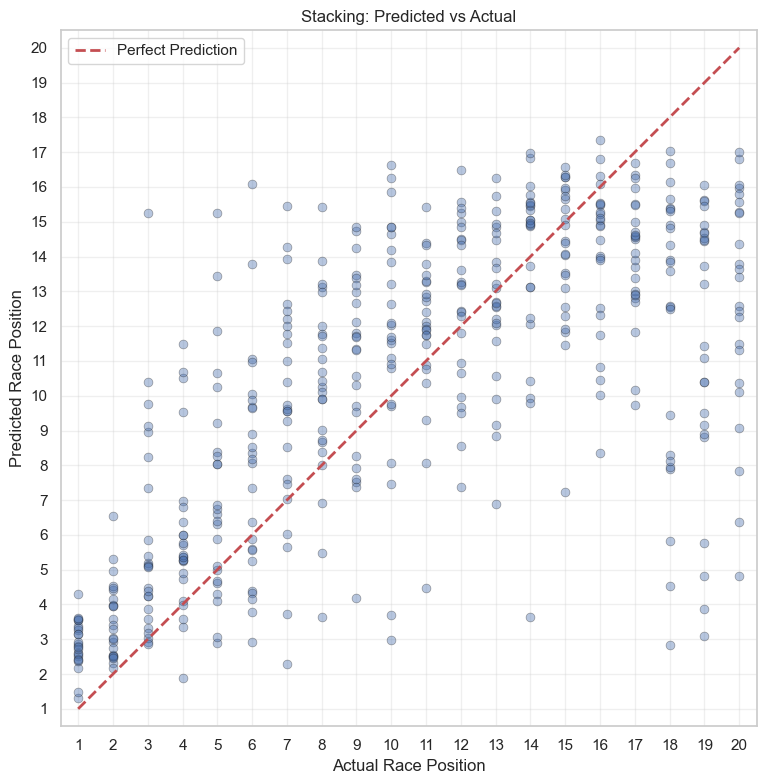

In [8]:
# Predicted vs Actual for each model
predictions = pipeline_results['predictions']
y_true = predictions['test_df']['race_position'].values

for name, pred_key in [('Random Forest', 'y_pred_random_forest'), ('XGBoost', 'y_pred_xgboost'), ('LightGBM', 'y_pred_lightgbm'), ('Stacking', 'y_pred_stacking')]:
    y_pred = np.clip(predictions[pred_key], 1, 20)
    fig = plot_predicted_vs_actual(y_true, y_pred, model_name=name)
    plt.show()

## 6. Cross-Validation Analysis

In [9]:
# Cross-validation on training set
from sklearn.model_selection import GroupKFold, cross_val_score

X_train, y_train, feature_cols = prepare_data(train_df)
groups_train = (train_df['Year'].astype(str) + '_' + train_df['RoundNumber'].astype(str)).values

cv = GroupKFold(n_splits=5)

print("\n── 5-Fold Cross-Validation (Training Set) ──")
for name in ['random_forest', 'xgboost', 'lightgbm', 'stacking']:
    model = models[name]
    if model is not None:
        scores = cross_val_score(
            model, X_train, y_train, 
            groups=groups_train, cv=cv,
            scoring='neg_mean_absolute_error'
        )
        mae_scores = -scores
        print(f"\n{name.replace('_', ' ').title()}:")
        print(f"  MAE per fold: {mae_scores.round(3)}")
        print(f"  Mean MAE: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")


── 5-Fold Cross-Validation (Training Set) ──

Random Forest:
  MAE per fold: [3.113 2.563 3.535 2.983 3.393]
  Mean MAE: 3.118 ± 0.339

Xgboost:
  MAE per fold: [3.109 2.514 3.565 2.969 3.389]
  Mean MAE: 3.109 ± 0.363

Lightgbm:
  MAE per fold: [3.075 2.505 3.56  3.007 3.358]
  Mean MAE: 3.101 ± 0.358

Stacking:
  MAE per fold: [3.052 2.52  3.624 2.876 3.297]
  Mean MAE: 3.074 ± 0.374


## 7. Summary

Key findings from model training to carry into the evaluation notebook.

In [10]:
# Find best model
best_model = min(results, key=lambda k: results[k]['mae'])
best_metrics = results[best_model]

print(f"\n{'='*60}")
print(f"📋 MODEL TRAINING SUMMARY")
print(f"{'='*60}")
print(f"""\n
Best Model: {best_model.replace('_', ' ').title()}
  MAE:          {best_metrics['mae']:.3f} positions
  RMSE:         {best_metrics['rmse']:.3f} positions
  Spearman ρ:   {best_metrics['spearman_rho']:.3f}
  NDCG@10:      {best_metrics.get('ndcg_10', 'N/A')}
  Top-3 Acc:    {best_metrics.get('top3_accuracy', 'N/A')}

Top 3 Features:
  1. {fi.iloc[0]['feature'] if len(fi) > 0 else 'N/A'} ({fi.iloc[0]['importance_pct'] if len(fi) > 0 else 'N/A'}%)
  2. {fi.iloc[1]['feature'] if len(fi) > 1 else 'N/A'} ({fi.iloc[1]['importance_pct'] if len(fi) > 1 else 'N/A'}%)
  3. {fi.iloc[2]['feature'] if len(fi) > 2 else 'N/A'} ({fi.iloc[2]['importance_pct'] if len(fi) > 2 else 'N/A'}%)

→ Proceed to Notebook 04 for detailed 2025 evaluation.
""")


📋 MODEL TRAINING SUMMARY


Best Model: Stacking
  MAE:          3.121 positions
  RMSE:         4.226 positions
  Spearman ρ:   0.670
  NDCG@10:      0.952
  Top-3 Acc:    0.764

Top 3 Features:
  1. grid_position (20.0%)
  2. quali_gap_to_pole (10.5%)
  3. team_quali_avg (8.600000381469727%)

→ Proceed to Notebook 04 for detailed 2025 evaluation.

